In [76]:
import os
import tarfile
import urllib
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [77]:
#load dataset

housing_data = pd.read_csv("/Users/chiragmacwan/Downloads/housing.csv")

In [78]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [79]:
# checkout the dataset

housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [80]:
# Fairly short dataset 
# total_bedrooms are 20433: total districts missing this feature = 207 (20640-20433)
# All numerical attributes except ocean_proximity, probably a categorcal attribute,
# so let's explore the categories and number of disctricts belong to them

housing_data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [81]:
# let's look at the other attribute
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

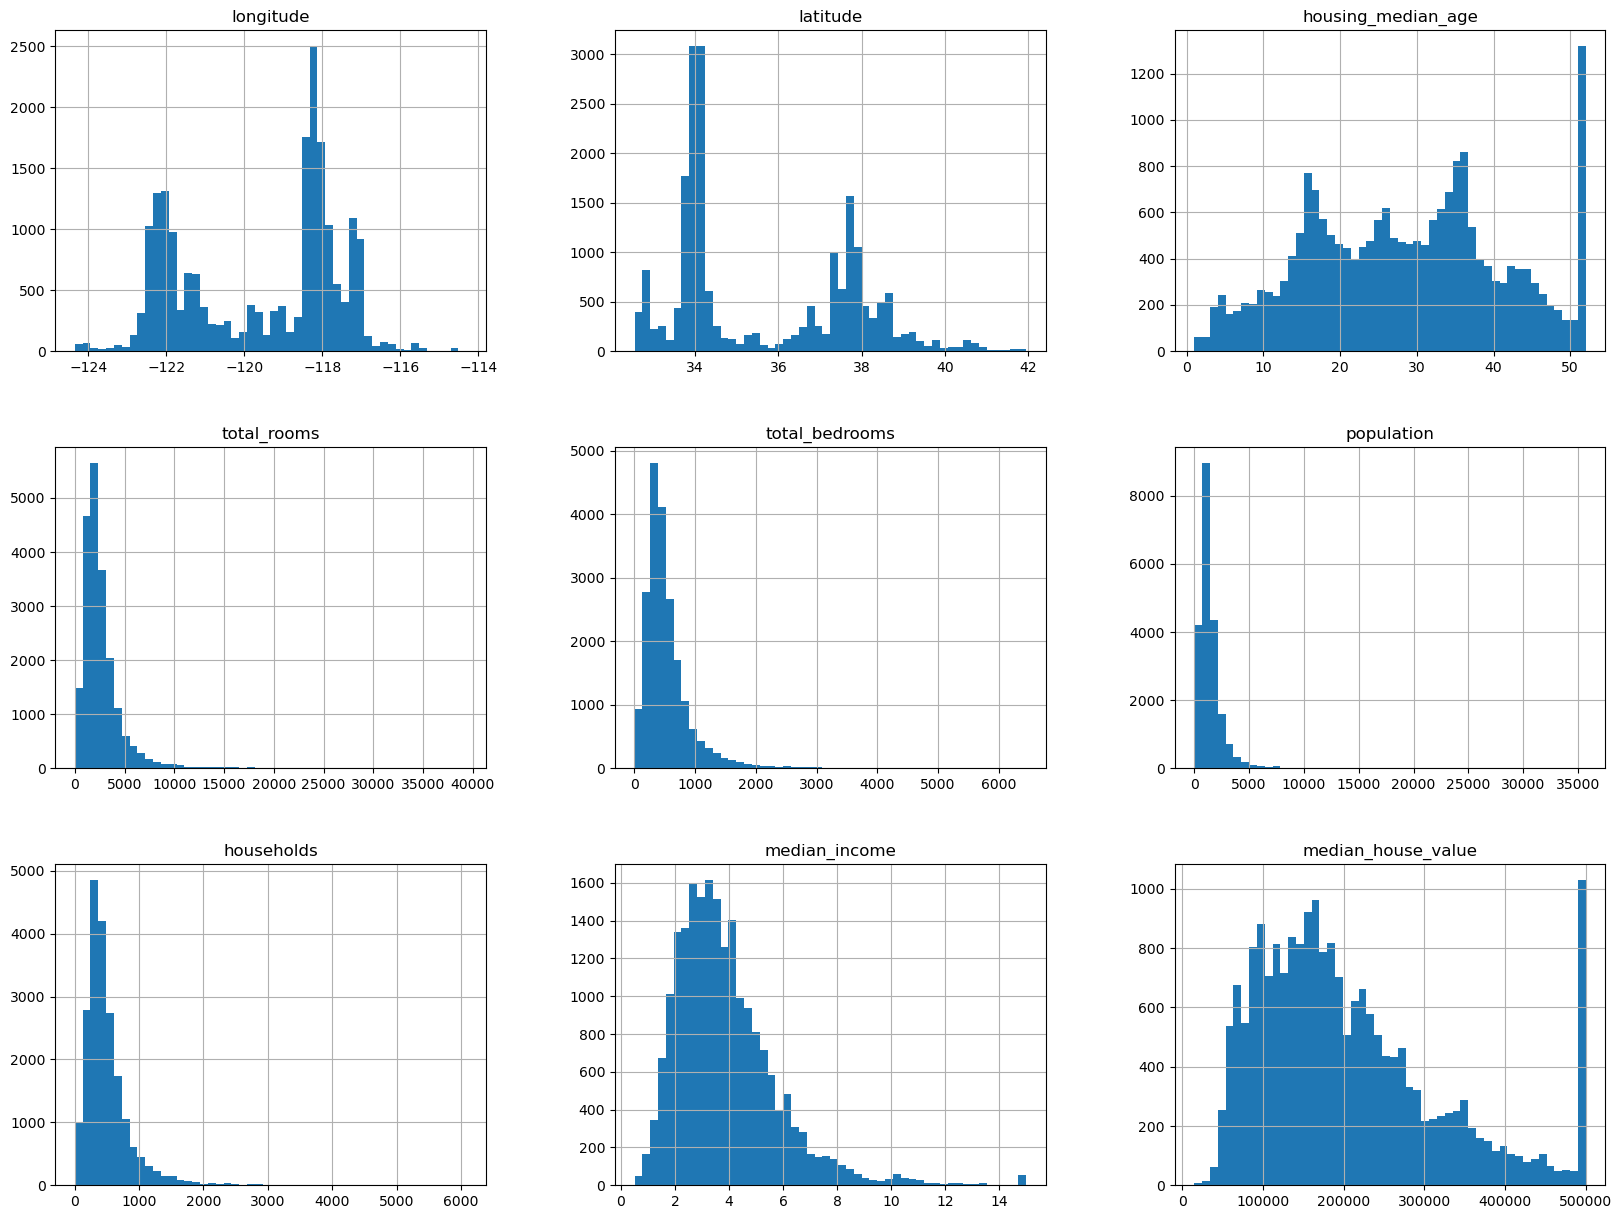

In [82]:
# a histogram to see each numerical attribute
housing_data.hist(bins=50, figsize=(20,15))

In [83]:
# notice median_income attribute does not look like in USD
# it's scaled and capped at 15 (15.0001) for higher median income and 0.5 (0.4999) for lower median income
# these number represent tens of thousands (e.g. 3 means $30,000)
# housing_median_age and median_house_value were also capped.

# Since median_house_value is the target variable in this regression task, 
# the algorithm might learn to never go beyond limit

# So, options : 1) collect proper labels for districts with capped labels 
#            or 2) remove such districts from training and test sets for the system to correctly predict beyond limit


In [84]:
# create a test set
# we can do random sampling but it might not be the most appropriate strategy, 
# since it will not ensure the test data will be representitive of the whole dataset
# we can employ stratified sampling using sklearn inbuild function
# consider that median income is very important attribute to predict the median house price.
# and we want to ensure that the test set is representitive of the various categories of incomes in the whole ds
# for this, firstly we can create a new income category attribute.
# notice most median income values are clustured around 1.5 to 6, but it goes beyond 6 as well (check histograms)
# therefore, to tackle this sort of bais, we must have sufficient number of instances for each homogenous group (strata)
# also, we should not have too many strat, and each strat should be large enough

<AxesSubplot:>

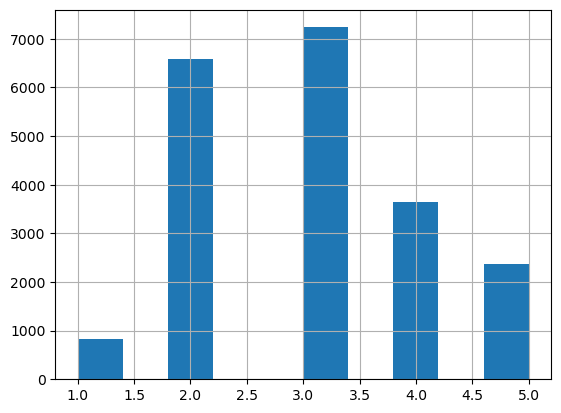

In [85]:
housing_data["income_cat"] = pd.cut(housing_data["median_income"],
                                   bins=[0.,1.5,3.0,4.5,6., np.inf],
                                   labels=[1,2,3,4,5])
housing_data["income_cat"].hist()

In [86]:
from sklearn.model_selection import StratifiedShuffleSplit

In [87]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_data, housing_data["income_cat"]):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

In [88]:
#check out the income category proportions now
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [89]:
#now we are goot to remove the income_cat attribute to bring the data to it's original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

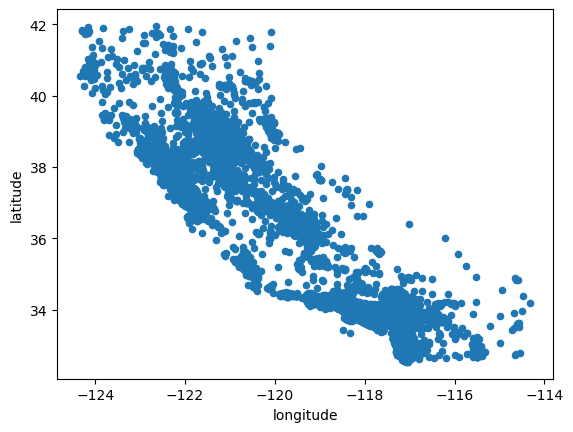

In [90]:
# now we can learn more about the data, discover and visualize
#starting with geographical visualization

#first create a copy of training data for exploration, we will use training set for exploration and Visualization
housing_copy = strat_train_set.copy()

housing_copy.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

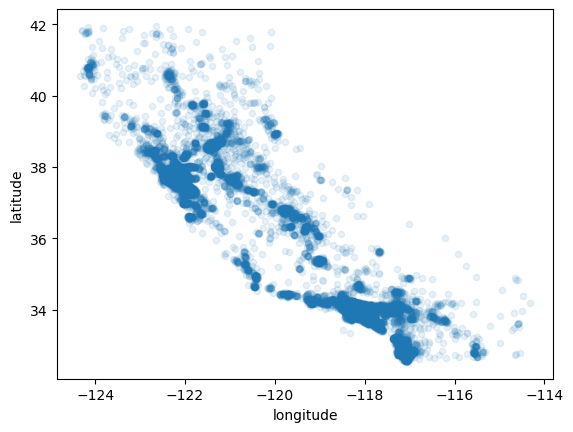

In [91]:
#let's set alpha to 0.1 to see the high density data points
housing_copy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

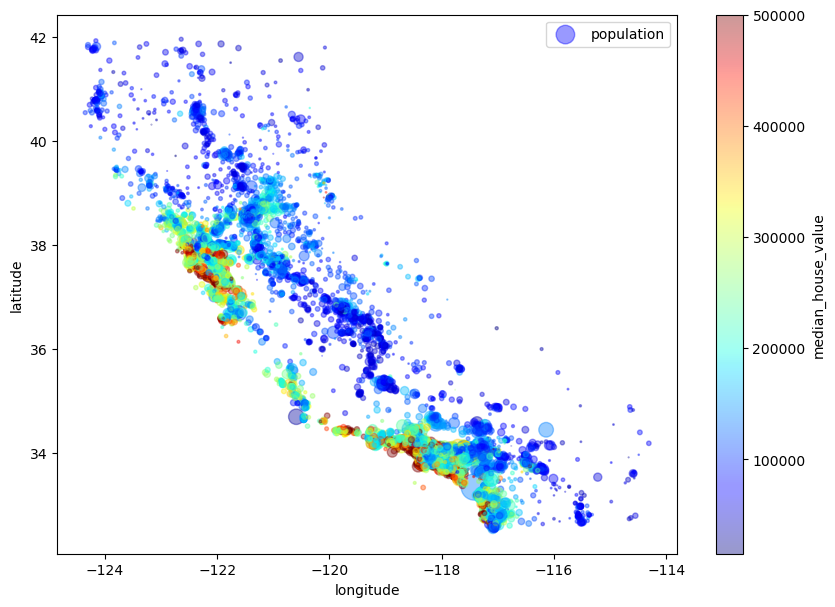

In [92]:
# now we can use cmap to visualize housing prices as well
housing_copy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
                  s=housing_copy["population"]/100, label="population", figsize=(10,7),
                  c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

In [93]:
# red : most expensive houses
# blue :  cheap houses
# larger circles indicates larger population

In [94]:
# from this plot we can easily figure out that prices are very much related to their locations and to the population density
# a clusturing algorithm should be useful to detect main cluster and adding new features that measure the proximity to cluster centres
# we have ocean_proximity attribute which can be helpful, but it won't be very simple rule
# since in the northern coastl area the prices are not too high

In [95]:
# let's look at the correlation each attribute has with the median_house_value
corr_matrix = housing_copy.corr()

In [96]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [97]:
# the correlation coefficient ranges from -1 to 1.
# if it's close to 1, meaning strong positive correlation: e.g. as median_income goes up, house value goes up
# if it's close to -1, meaning strong negative correlation: e.g. notice a small megative correlation between latitude and house value
# finally, coefficient close to 0 meaning no strong linear correlation

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

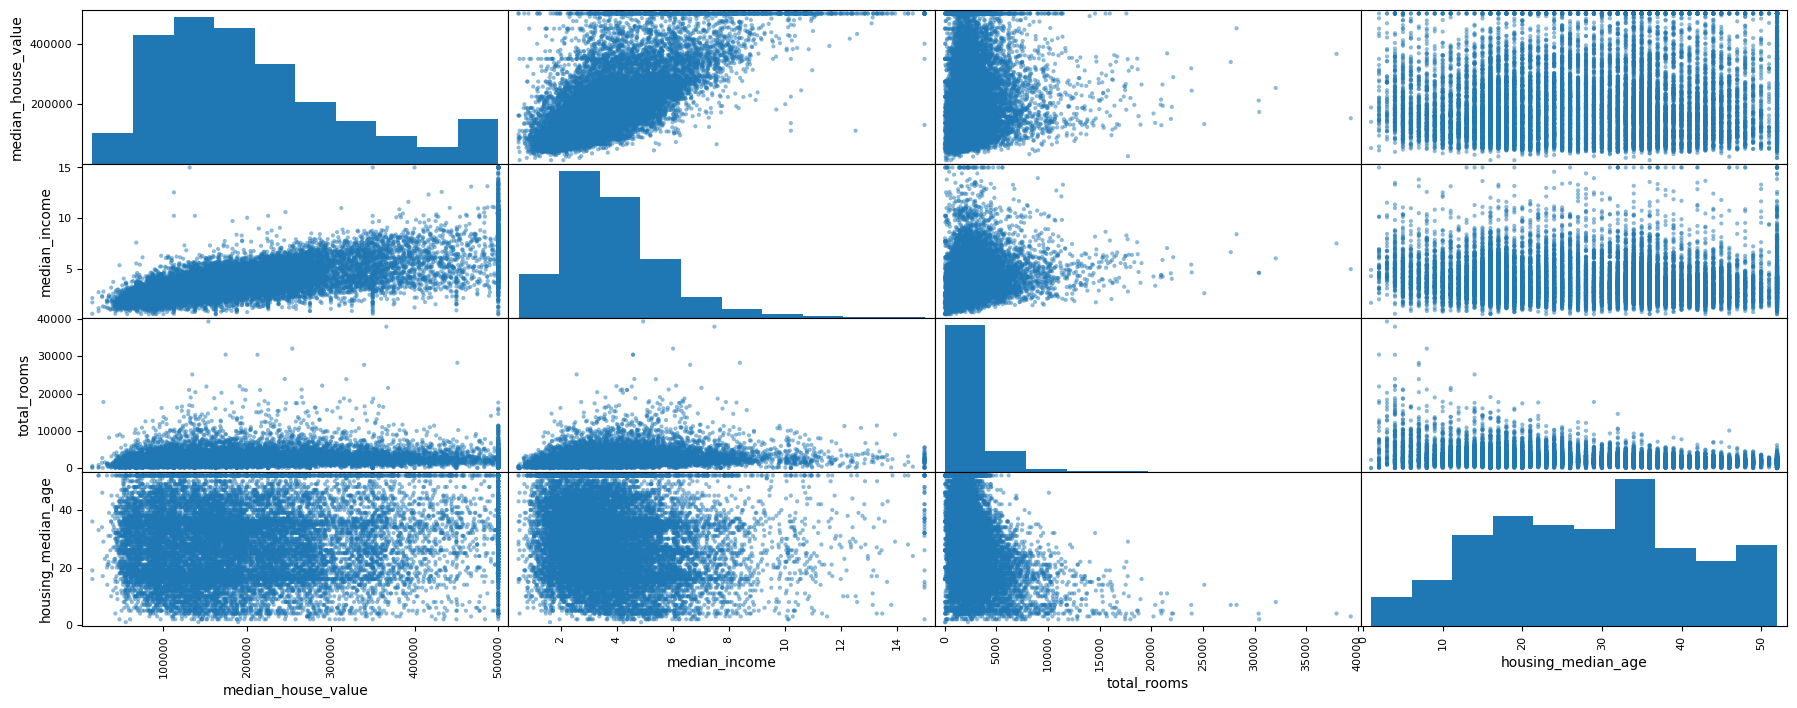

In [98]:
# let's plot imporant attributes in scatter_matrix to learn more about correlation
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing_copy[attributes], figsize=(22,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

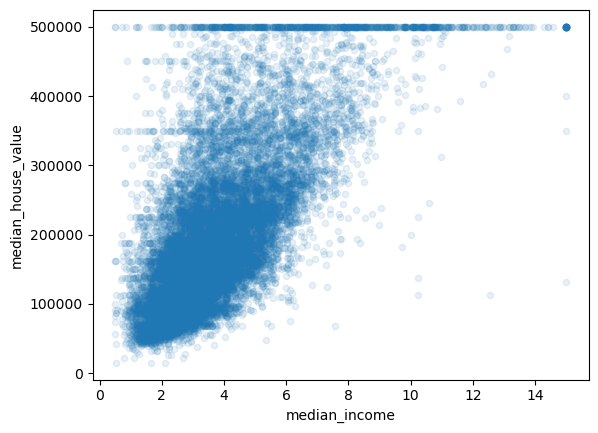

In [99]:
# from this plot the strongest correlation could be with median income
# let's look at it in detail
housing_copy.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [100]:
# few things to notice : 1) indeed the correlation is strong, a clear upword trend
# 2) the price cap is noticable, a clear blue line at 500,000
# 3) there are other obvious straight lines, notice a horizontal line near 450,000, 350,000 also near 280,000
# we may want to try removing corresponding disctricts to prevent algorithm from learning these data quirks.

In [101]:
# there are multiple attritubes which can be more meaningful if we can combine
# e.g. total number of rooms in a district is not a very useful attribute if we don't know how many households are there
# we actually needs rooms per household
# similarly, instead of number of bedrooms per district are not useful, probably come it with number of rooms
# Also, population per household also seems like interesting attribute combination

In [102]:
# try creating above mentioned attributes
housing_copy["rooms_per_household"] = housing_copy["total_rooms"]/housing_copy["households"]
housing_copy["bedrooms_per_room"] = housing_copy["total_bedrooms"]/housing_copy["total_rooms"]
housing_copy["population_per_household"] = housing_copy["population"]/housing_copy["households"]

In [103]:
#now let's check the correlation matrix

corr_matrix = housing_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [104]:
# we can see our new attribute bedroom_per_room is much more correlated
# number of rooms per household is also more correlated than total number of rooms in a disctrict

In [105]:
#now let's start preparing our data for ML Algorithm
housing_copy = strat_train_set.drop("median_house_value", axis=1)
housing_label = strat_train_set["median_house_value"].copy()

In [106]:
#ML Algorithm can not work with missing values, we have missing values in total_bedrooms
#here are the options if we decide to drop them
    #1) housing_copy.dropna(subset=["total_bedrooms"])
    #2) housing_copy.drop("total_bedrooms", axis=1)
#if we decide to take a median value
    #1) median = housing_copy["total_bedrooms"].median()
    #2) housing["total_bedrooms"].fillna(median, inplace=True)
#Scikit-Learn has SimpleImputer class to take care of missing values

In [107]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

#note that median can only work on numerical attribute, 
#we have non-numeric attribute, ocean_proximity
#therefore we must create a copy of data without ocean_proximity attribute

housing_num = housing_copy.drop("ocean_proximity", axis=1)

In [108]:
# now we are ready to fit the imputer instance to the training data using fit() method
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [109]:
# imputer has simply computed the median of each attribute and stored the result in the statistics_ instance variable
# we have only total_bedroom attribute had missing values
# but our imputer calculated median for all attributes since we can't be sure that in future that won't be any missing value

imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [110]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [111]:
# now we are ready to use the trained imputer to transform the training set by replacing missing values with learned medians

X = imputer.transform(housing_num)

In [112]:
# this will give a simple numpy array but tranforming back to pandas df is simple
housing_tf = pd.DataFrame(X, columns=housing_num.columns,
                         index=housing_num.index)

In [113]:
# now let's handle our text as well as categorical attributes
housing_cat = housing_copy[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [114]:
# since it's a categorical attribute, we can convert the categories to numbers
# remember most ML Algorithms prefer numerical values
# converting these text categories to numbers requires another Scikit Learn class : OrdinalEncoder

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoder = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoder[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [115]:
# we can also see the category values 
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [116]:
# this is very helpful but there's one issue with this representation
# ML Algorithm will assume that two nearby values will be more similar than two distant values.
# in some cases this is fine, where categories are bad, average, good, very good, excellent etc
# for our attribute this is not the case
# to tackle this issue, we can create one binary attribute per category: one category equal to 1 when the category is "<1H OCEAN" (and 0 otherwise) so on
# this process is called one-hot encoding
# the new attributes are called dummy attributes
# Scikit Learn provides this facility with OneHotEncoder class

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [117]:
# again, we can checkout the categories with encoder's categories_ instance variable
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [118]:
# apply some custom transformation

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_copy.values)

In [119]:
#scikit Learn has Pipeline class that allows all the transformation do happen in right order
#this includes transformation for non-numeric features as well

In [120]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler',StandardScaler())
                        ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [121]:
# pipeline for numerical and non-numerical attributes combined

from sklearn.compose import ColumnTransformer

num_attributes = list(housing_num)
cat_attributes = ["ocean_proximity"]

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attributes),
                                   ("cat", OneHotEncoder(), cat_attributes)])
housing_prepared = full_pipeline.fit_transform(housing_copy)

In [122]:
# selecting a model
# first let's train and evaluate on the training set, first LinearRegression

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_label)

# Done! We have a linear model now

LinearRegression()

In [123]:
#let's predict some numbers
some_data = housing_copy.iloc[:5]
some_labels = housing_label.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [124]:
# see that the predictions are not very accurate
# let's measure the RMSE 

from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_label, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [125]:
# CAD 68627 is not a satsifying difference 
# this is example model which is underfitting the data,
# this means the features do not provide enough info to make good predictions or the model is not powerful enough
# first option, let's try another more complex model : DecisionTreeRegressor

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_label)

DecisionTreeRegressor()

In [126]:
# Second model is trained and ready, let's evaluate on training set
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_label, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [127]:
# No error, mean model badly overfits the data
# Let's do better evaluation using cross-validation : k-fold corss validation which allows 10 distinct folds (small training sets from our training set)
# it will train and evaluate our model 10 times for 10 folds, each time one against other 9.
# this will output an array of 10 scores

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_label, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [128]:
# define a function to check these socres
def display_scores(scores):
    print(scores)
    print("mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())
display_scores(tree_rmse_scores)

[72086.91604789 69829.04048861 68398.77106637 71498.77613227
 70446.2297504  78088.27677165 72010.17367331 71677.14120508
 67470.0603295  70692.52197301]
mean:  71219.79074380946
Standard Deviation:  2714.2022679660336


In [129]:
# now we can see this is also not a great model
# cross validation score provides with estimate of performance but it also tells how prescise the estimate is by showing Standard Daviation
# let's compute cross validation scores for our liner model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_label, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

[71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
mean:  69104.07998247063
Standard Deviation:  2880.3282098180657


In [130]:
# now we can see infact our linear model is better than decision tree model (overfitted badly)
# we can try another model : RandomForestRegressor : it works by training many decision trees on many subset of the features and then it averages the predictions
# this is assamble learning algorith as it's a model built on many models, and it's a way to push ML algorithm further

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_label)

# done! third model! now let's evaluate!

RandomForestRegressor()

In [131]:
rf_scores = cross_val_score(forest_reg, housing_prepared, housing_label, scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
display_scores(rf_rmse_scores)

[51496.37431438 48981.09525255 47201.92900992 51792.6016543
 47381.32119666 51922.16689957 52433.11399566 49782.03411828
 48860.12504623 53625.04575679]
mean:  50347.58072443424
Standard Deviation:  2099.3291805958975


In [132]:
# we can save every model we build
import joblib

joblib.dump(forest_reg, "randomforestregg.pkl")
joblib.dump(tree_reg, "decisiontreeregg.pkl")
joblib.dump(lin_reg, "linregg.pkl")

['linregg.pkl']

In [150]:
# assume we are selecting some models 
# now let's finetune them
# one way to optimize our model is to manually find the best hyperparameter for our model, but it's tidious and time consuming
# Scikit-learn provides GridSearchCV to search optimal hyperparameter for our model
# GridseachCV will use corss-validation to seach for the optimal hyperparameter

from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators':[3, 10, 20, 25, 30, 35, 40], 'max_features':[2,4,6,7,8,10,12]},
              {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]},]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_label)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 7, 8, 10, 12],
                          'n_estimators': [3, 10, 20, 25, 30, 35, 40]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [151]:
grid_search.best_params_

{'max_features': 7, 'n_estimators': 40}

In [152]:
# analyze the best model
feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([7.33989726e-02, 6.64157928e-02, 4.29448473e-02, 1.66028573e-02,
       1.53797085e-02, 1.63553388e-02, 1.52167288e-02, 3.78146119e-01,
       4.70972173e-02, 1.10695739e-01, 5.91799514e-02, 7.09089030e-03,
       1.44992806e-01, 6.13255704e-05, 2.61820786e-03, 3.80349753e-03])

In [153]:
extra_attr = ["rooms_per_hhold", "pop_per_hhold", "bedroom_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attributes + extra_attr + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse=True)

[(0.3781461186995603, 'median_income'),
 (0.14499280612725174, 'INLAND'),
 (0.1106957391406344, 'pop_per_hhold'),
 (0.0733989725653609, 'longitude'),
 (0.06641579277310068, 'latitude'),
 (0.059179951422102334, 'bedroom_per_room'),
 (0.04709721726092342, 'rooms_per_hhold'),
 (0.04294484734798957, 'housing_median_age'),
 (0.016602857311534835, 'total_rooms'),
 (0.01635533876599234, 'population'),
 (0.015379708495251772, 'total_bedrooms'),
 (0.015216728829995049, 'households'),
 (0.00709089030143185, '<1H OCEAN'),
 (0.0038034975256865527, 'NEAR OCEAN'),
 (0.0026182078628145915, 'NEAR BAY'),
 (6.132557036959102e-05, 'ISLAND')]

In [154]:
#now is the time to evaluate the model on the test set
# we will run our full pipeline to transform the data, we will call transform() method instad of fit_transform - we do not want to fit the test set!

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [156]:
final_predictions = final_model.predict(X_test_prepared)
final_predictions

array([484848.325, 231707.55 , 206057.5  , ..., 364732.55 , 265087.525,
       228337.5  ])

In [157]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [159]:
print("Predictions: ", final_predictions[:10])
print("Labels: ", list(y_test)[:10])

Predictions:  [484848.325 231707.55  206057.5   177367.5   234037.525 160657.5
 128787.5   442695.25  245310.    290470.125]
Labels:  [500001.0, 162500.0, 204600.0, 159700.0, 184000.0, 151900.0, 104900.0, 500001.0, 367400.0, 346500.0]


In [ ]:
#[484848.325 231707.55  206057.5   177367.5   234037.525  160657.5  128787.5   442695.25  245310.    290470.125]
#[500001.0,  162500.0,  204600.0,  159700.0,  184000.0,   151900.0, 104900.0,  500001.0,  367400.0,  346500.0]